# DQN for frozen lake

In [1]:
# will take some of miguel's import statements, but not all.
import gym
# import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
# from itertools import count
# from PIL import Image
# import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary

In [2]:
!nvidia-smi

Sun Apr 17 22:36:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.54       Driver Version: 510.54       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
|  0%   36C    P8     6W / 151W |    444MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
"""
    Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over
    the Frozen(F) lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake.
    ### Action Space
    The agent takes a 1-element vector for actions.
    The action space is `(dir)`, where `dir` decides direction to move in which can be:
    - 0: LEFT
    - 1: DOWN
    - 2: RIGHT
    - 3: UP
    ### Observation Space
    The observation is a value representing the agent's current position as
    current_row * nrows + current_col (where both the row and col start at 0).
    For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.
    The number of possible observations is dependent on the size of the map.
    For example, the 4x4 map has 16 possible observations.
    ### Rewards
    Reward schedule:
    - Reach goal(G): +1
    - Reach hole(H): 0
    - Reach frozen(F): 0
    ### Arguments
    ```
    gym.make('FrozenLake-v1', desc=None,map_name="4x4", is_slippery=True)
    ```
    `desc`: Used to specify custom map for frozen lake. For example,
        desc=["SFFF", "FHFH", "FFFH", "HFFG"].
    `map_name`: ID to use any of the preloaded maps.
        "4x4":[
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
            ]
        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG",
        ]
    `is_slippery`: True/False. If True will move in intended direction with
    probability of 1/3 else will move in either perpendicular direction with
    equal probability of 1/3 in both directions.
        For example, if action is left and is_slippery is True, then:
        - P(move left)=1/3
        - P(move up)=1/3
        - P(move down)=1/3
    ### Version History
    * v1: Bug fixes to rewards
    * v0: Initial versions release (1.0.0)
    """

env = gym.make('FrozenLake-v1', is_slippery=False)
print("Action space: ", env.action_space)
print("Observation space: ", env.observation_space)
n_action = 4
n_states = 16

Action space:  Discrete(4)
Observation space:  Discrete(16)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [5]:
# create a replay buffer
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'terminal'))


class ReplayBuffer(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def save(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
# miguel has an image based version, I need to start with a state based one... 
class simpleModel(nn.Module):

    def __init__(self, in_features=n_states, outputs=n_action):
        super(simpleModel, self).__init__()
        self.linear1 = nn.Linear(in_features, 64)
        self.linear2 = nn.Linear(64, 16)
#         self.linear3 = nn.Linear(128, 64)
        self.final = nn.Linear(16, outputs)
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, x):
        x = self._format(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
#         x = F.relu(self.linear3(x))
        x = F.relu(self.final(x))
        return x
    
    def load(self, experiences):
        batch = Transition(*zip(*experiences))
        
        states = np.array(batch.state)
        actions = np.array(batch.action)
        new_states = np.array(batch.next_state)
        rewards = np.array(batch.reward)
        is_terminals = np.array(batch.terminal)
        
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        new_states = torch.from_numpy(new_states).float().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        is_terminals = torch.from_numpy(is_terminals).float().to(device)
        return states, actions, new_states, rewards, is_terminals

In [7]:
online_model = simpleModel()
target_model = simpleModel()
print(online_model)

simpleModel(
  (linear1): Linear(in_features=16, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (final): Linear(in_features=16, out_features=4, bias=True)
)


In [8]:
summary(online_model, input_size=(16,))

Layer (type:depth-idx)                   Output Shape              Param #
simpleModel                              --                        --
├─Linear: 1-1                            [64]                      1,088
├─Linear: 1-2                            [16]                      1,040
├─Linear: 1-3                            [4]                       68
Total params: 2,196
Trainable params: 2,196
Non-trainable params: 0
Total mult-adds (M): 0.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [9]:
# action selection strategy
def e_greedy_policy(model, epsilon, state, action_space=n_action):
    if np.random.random() < epsilon: # random action
        return np.random.randint(action_space)
    else:  # greedy
        q_values = model(state).cpu().detach()
        q_values = q_values.data.numpy()
        return np.argmax(q_values)
# convert interger state into one hot encoded values
def convert_state(num, size=16):
    state = np.zeros(size)
    state[num] = 1
    return state

In [10]:
# pre populate a starting library of experiences
memory = ReplayBuffer(50000)
initial_size = 5000

while len(memory) < initial_size:
    state = env.reset()
    state = convert_state(state)
    terminal = False
    
    while not terminal:
        action = env.action_space.sample()
        (next_state, reward, done, info) = env.step(action)
        next_state = convert_state(next_state)
        # slight modification of rewards
        if done:
            if reward == 0:
                reward = -0.1
        memory.save(state, action, next_state, reward, done)
        terminal = done
        state = next_state
print(len(memory), "entries saved to ReplayBuffer")

5001 entries saved to ReplayBuffer


In [11]:
%%time
n_episodes = 1000
reward_record = []
loss_record = []
update_interval = 50
epsilon=1.0
eps_decay = 0.9995
batch_size = 512
learning_rate = 0.005
gamma=1.0intpus
optimizer = optim.Adam(online_model.parameters(), lr=learning_rate)
# optimizer = optim.RMSprop(online_model.parameters(), lr=learning_rate)
count = 0

for episode in range(n_episodes):
    state = env.reset()
    state = convert_state(state)
    terminal = False
    
    while not terminal:         
        # select action
        action = e_greedy_policy(online_model, epsilon, state, action_space=n_action)
        (next_state, reward, done, info) = env.step(action)
        next_state = convert_state(next_state)
        # slight modification of rewards
        if done:
            if reward == 0:
                reward = -0.1
        memory.save(state, action, next_state, reward, done)
        terminal = done
        state = next_state
        count += 1
        
        # sample random minibatch
        transitions = memory.sample(batch_size)
        (states, actions, new_states, rewards, is_terminals) = online_model.load(transitions)
        
        # Q target
        continue_mask = 1 - is_terminals  # if terminal, then = 0
        Q_next = target_model(new_states).detach()  # gradient does NOT involve the target
        Q_next_max = Q_next.max(1)[0]  # (batch_size)
        Q_target = rewards + Q_next_max * continue_mask * gamma
        Q_target = Q_target.unsqueeze(1) # (batch_size x 1)

        # fit the model
        Q_values = online_model(states).gather(1, actions.unsqueeze(1)) # batch_size x 1
        criterion = torch.nn.MSELoss()
        loss = criterion(Q_values, Q_target)
        loss_value = loss.data.cpu().numpy().copy()

        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update target network periodically
        if count % update_interval == 0:
            # print("updating target model")
            for target, online in zip(target_model.parameters(), online_model.parameters()):
                target.data.copy_(online.data)

    reward_record.append(reward)
    loss_record.append(loss_value)
    
    epsilon = max(epsilon*eps_decay, 0.005)
    if episode % 50 == 0:
         print("episode", episode, "epsilon", round(epsilon, 3), "reward", reward, "loss", loss_value)
    #     # save best weights
    #     if tmp_reward > best_score:
    #         best_score = tmp_reward
    #         print("episode", episode, "new best score", best_score, "rolling avg", rolling_average)
    

episode 0 epsilon 1.0 reward -0.1 loss 0.008013577
episode 50 epsilon 0.975 reward -0.1 loss 0.0019000997
episode 100 epsilon 0.951 reward -0.1 loss 0.0019830628
episode 150 epsilon 0.927 reward -0.1 loss 0.0059993197
episode 200 epsilon 0.904 reward -0.1 loss 0.0041647893
episode 250 epsilon 0.882 reward -0.1 loss 0.0024487376
episode 300 epsilon 0.86 reward -0.1 loss 0.0020853542
episode 350 epsilon 0.839 reward -0.1 loss 0.00430198
episode 400 epsilon 0.818 reward -0.1 loss 0.0020530587
episode 450 epsilon 0.798 reward -0.1 loss 0.0019489591
episode 500 epsilon 0.778 reward -0.1 loss 0.00791182
episode 550 epsilon 0.759 reward -0.1 loss 0.0020842943
episode 600 epsilon 0.74 reward -0.1 loss 0.0017578528
episode 650 epsilon 0.722 reward -0.1 loss 0.0020606976
episode 700 epsilon 0.704 reward -0.1 loss 0.0058247834
episode 750 epsilon 0.687 reward -0.1 loss 0.00191245
episode 800 epsilon 0.67 reward -0.1 loss 0.0037607308
episode 850 epsilon 0.653 reward -0.1 loss 0.00400931
episode 9

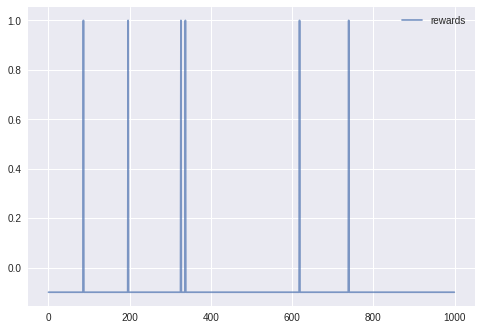

In [12]:
plt.style.use('seaborn')
plt.plot(np.arange(0, n_episodes), reward_record, alpha=0.7, label='rewards')
plt.legend()

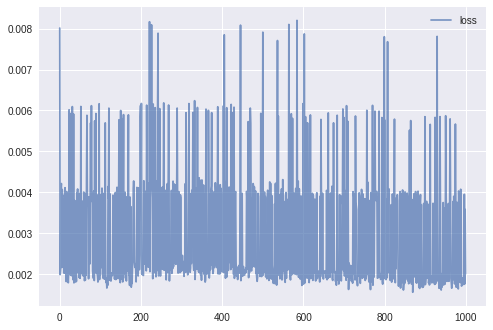

In [13]:
plt.style.use('seaborn')
plt.plot(np.arange(0, n_episodes), loss_record, alpha=0.7, label='loss')
plt.legend()

In [14]:
def run_dqn():
    online_model = simpleModel()
    target_model = simpleModel()
    
    n_episodes = 1000
    reward_record = []
    avg_rewards_list = []
    avg_record = [0]
    best_score = 75
    update_interval = 150
    epsilon=0.9
    batch_size = 64
    learning_rate = 0.0005
    gamma=0.95
    # optimizer = optim.Adam(online_model.parameters(), lr=learning_rate)
    optimizer = optim.Adam(online_model.parameters(), lr=learning_rate)
    count = 0

    for episode in range(n_episodes):
        state = env.reset()
        state = convert_state(state)
        terminal = False

        while not terminal:         
            # select action
            action = e_greedy_policy(online_model, epsilon, state, action_space=n_action)
            (next_state, reward, done, info) = env.step(action)
            next_state = convert_state(next_state)
            # slight modification of rewards
            if done:
                if reward == 0:
                    reward = -0.1
            memory.save(state, action, next_state, reward, done)
            terminal = done
            state = next_state
            count += 1

            # sample random minibatch
            transitions = memory.sample(batch_size)
            (states, actions, new_states, rewards, is_terminals) = online_model.load(transitions)

            # Q target
            continue_mask = 1 - is_terminals  # if terminal, then = 0
            Q_next = target_model(new_states).detach()  # gradient does NOT involve the target
            Q_next_max = Q_next.max(1)[0]  # (batch_size)
            Q_target = rewards + Q_next_max * continue_mask * gamma
            Q_target = Q_target.unsqueeze(1) # (batch_size x 1)

            # fit the model
            Q_values = online_model(states).gather(1, actions.unsqueeze(1)) # batch_size x 1
            criterion = torch.nn.MSELoss()
            loss = criterion(Q_values, Q_target)
            loss_value = loss.data.cpu().numpy().copy()

            # optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update target network periodically
            if count % update_interval == 0:
                # print("updating target model")
                for target, online in zip(target_model.parameters(), online_model.parameters()):
                    target.data.copy_(online.data)

        reward_record.append(reward)
        loss_record.append(loss_value)
        avg_rewards_list.append(np.mean(reward_record[-10:]))
        
    return avg_rewards_list, loss_record

In [15]:
%%time
rolling_record = []
for trial in range(5):
    rewards_record, loss_record = run_dqn()
    rolling_record.append(rewards_record)
    print("rep max rolling rewards", max(rewards_record))

rep max rolling rewards 0.12
rep max rolling rewards 0.22999999999999998
rep max rolling rewards 0.22999999999999998
rep max rolling rewards 0.12
rep max rolling rewards 0.12
CPU times: user 39.3 s, sys: 306 ms, total: 39.6 s
Wall time: 39.4 s


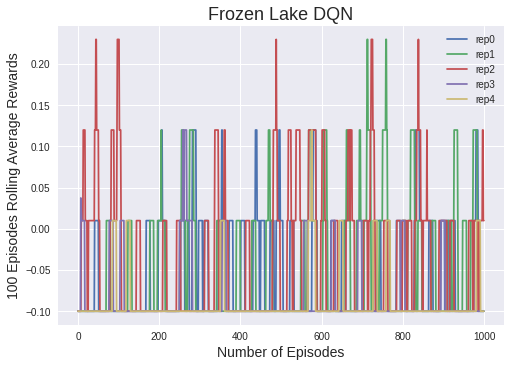

In [16]:
plt.style.use('seaborn')
plt.figure()
plt.title('Frozen Lake DQN', fontsize = 18)
plt.xlabel("Number of Episodes", fontsize=14)
plt.ylabel("100 Episodes Rolling Average Rewards", fontsize=14)
for record in rolling_record:
    plt.plot(record)
plt.savefig("FrozenLake_dqn.png")
plt.legend(labels=['rep0', 'rep1', 'rep2', 'rep3', 'rep4'])

In [ ]:
# np.save('dqn_results.npy', np.array(rolling_record))
# np.load('dqn_results.npy')

In [ ]:
# # load saved model
# model = simpleModel()
# optimizer = optim.Adam(model.parameters())

# checkpoint = torch.load(name)
# print(name, "loaded")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [23]:
action = e_greedy_policy(online_model, epsilon, state, action_space=n_action)
action

0

In [24]:
state

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])